# ANN: Regression (Website Traffic)

## Imports

First we do all installations and imports

In [38]:
# pip install scikit-learn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import metrics

# pip install tensorflow
import tensorflow as tf
import keras
from keras import layers

## Loads and process data

The csv file is loaded and we check the columns

In [39]:
df = pd.read_csv("./Data/website_data.csv")

In [40]:
df.columns

Index(['Page Views', 'Session Duration', 'Bounce Rate', 'Traffic Source',
       'Time on Page', 'Previous Visits', 'Conversion Rate'],
      dtype='object')

Now we exclude Conversion Rate. We will now try to use Time on Page as target.

In [41]:
df = df[['Page Views', 'Session Duration', 'Bounce Rate',
       'Time on Page', 'Previous Visits']]

With the code below, we try to take care of possble outliers from the dataframe

In [42]:
from scipy import stats
df = df[(np.abs(stats.zscore(df)) < 3).all(axis=1)]

In [43]:
df.head()

,Page Views,Session Duration,Bounce Rate,Time on Page,Previous Visits
0,5,11.05,0.23,3.89,3
1,4,3.43,0.39,8.48,0
2,4,1.62,0.40,9.64,2
3,5,3.63,0.18,2.07,3
4,5,4.24,0.29,1.96,5


## X en y-variabelen definieren

In [44]:
X = df[['Page Views', 'Bounce Rate', 'Previous Visits', 'Session Duration']]
# X = df[['Bounce Rate', 'Time on Page',
#         'Previous Visits', 'Conversion Rate']]
y = df[['Time on Page']]

## Optimal variables

We want to optimize the selection of used variables in the ANN. We use a correlation table to visualise the correlation between every variable. The correlations are a number between -1 and 1, high correlations can cause redundancy => overfitting, ineficiency, ... So the point of doing the following step is to see if we can leave one or more higly correlated variables behind before proceeding to the ANN

In [45]:
# !pip install pandasgui
from pandasgui import show

correlations = df.corr()
show(correlations)

PandasGUI INFO — pandasgui.gui — Opening PandasGUI
C:\Users\ruben\AppData\Local\Temp\ipykernel_19956\1652946242.py:5: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

C:\Users\ruben\AppData\Local\Temp\ipykernel_19956\1652946242.py:5: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

C:\Users\ruben\AppData\Local\Temp\ipykernel_19956\1652946242.py:5: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

C:\Users\ruben\AppData\Local\Temp\ipykernel_19

We can see from the grid that there's no significant correlation between variables

Now in the next code part, let's go over feature importance using KBest selection

In [46]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

# convert all continuous variables to integer,
# and convert all negative numbers to 0
X_cat = X.astype(int)
X_cat = X_cat.clip(lower=0)

# initialize chi2 and SelectKBest
# Note: chi2 -test is a very common test
# in statistics and quantitative analysis
# basically it studies the data whether variables are related
# or independent of each other
chi_2_features = SelectKBest(chi2, k=len(X_cat.columns))

# fit our data to the SelectKBest
best_features = chi_2_features.fit(X_cat,y.astype(int))

# use decimal format in table print later
pd.options.display.float_format = '{:.2f}'.format

# wrap it up, and show the results
# the higher the score, the more effect that column has on price
df_features = pd.DataFrame(best_features.scores_)
df_columns = pd.DataFrame(X_cat.columns)
f_scores = pd.concat([df_columns,df_features],axis=1)
f_scores.columns = ['Features','Score']
f_scores.sort_values(by='Score',ascending=False)

,Features,Score
3,Session Duration,53.16
2,Previous Visits,9.39
0,Page Views,8.08
1,Bounce Rate,NaN


From this output we can conclude that Session Duration and Time on Page are the two most important features who have the stronges relation with the target variable => Conversion Rate. It is weird that Bounce Rate gets a NaN.

In [47]:
print(df['Bounce Rate'].isnull().sum())
print(df['Bounce Rate'].nunique())
# No weird output so that's strange...

0
1907


## Test/train/validation-split

In [48]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=101)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=101)

## Neural Network

Now the fun part... creating the model. I started with a simple model with 3 layers, but the results were very bad. I tried a lot of different combinations, and even added Dropout layers, but the metrics are still very bad. We set the target variable to be "Conversion Rate", so that's the one we're predicting

In [51]:
model = keras.Sequential(
    [
        layers.Dense(18, activation="relu", input_shape=(4,)),
        layers.Dropout(0.3),
        layers.Dense(65, activation="relu"),
        layers.Dropout(0.3),
        layers.Dense(130, activation="relu"),
        layers.Dropout(0.3),
        layers.Dense(32, activation="relu"),
        layers.Dense(1)
    ]
)

model.compile(optimizer='adam', loss='mse')

model.summary()

C:\Users\ruben\anaconda3\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_14 (Dense)                     │ (None, 18)                  │              90 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 18)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 65)                  │           1,235 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 65)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 130)                 │           8,580 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 130)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 32)                  │           4,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,130 (55.20 KB)

 Trainable params: 14,130 (55.20 KB)

 Non-trainable params: 0 (0.00 B)

## Start training of NN

In [52]:
model.fit(x=X_train, y=y_train, epochs=500, validation_data=(X_val, y_val))

Epoch 1/500
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 13.8506 - val_loss: 10.4744
Epoch 2/500
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.0528 - val_loss: 10.0549
Epoch 3/500
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.6752 - val_loss: 8.9406
Epoch 4/500
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.1549 - val_loss: 8.9831
Epoch 5/500
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.4316 - val_loss: 8.3706
Epoch 6/500
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.1032 - val_loss: 8.3832
Epoch 7/500
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.2238 - val_loss: 7.7776
Epoch 8/500
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.6195 - val_loss: 7.7459
Epoch 9/500
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.0971 - val_loss: 7.8778
Epoch 10/500
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.7217 - val_loss: 7.1539
Epoch 11/500
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.7939 - val_loss: 8.1023
Epoch 12/500
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 

42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.4245 - val_loss: 6.8619
Epoch 70/500
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.5022 - val_loss: 6.9077
Epoch 71/500
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.9506 - val_loss: 6.9180
Epoch 72/500
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.5078 - val_loss: 6.8385
Epoch 73/500
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.0905 - val_loss: 6.8493
Epoch 74/500
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.8558 - val_loss: 6.8885
Epoch 75/500
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.0080 - val_loss: 6.9030
Epoch 76/500
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.3470 - val_loss: 6.8435
Epoch 77/500
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.7315 - val_loss: 6.8590
Epoch 78/500
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.4999 - val_loss: 6.8604
Epoch 79/500
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.2453 - val_loss: 6.8508
Epoch 80/500
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.4257 

42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.4526 - val_loss: 6.8795
Epoch 138/500
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.8515 - val_loss: 6.8714
Epoch 139/500
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.1148 - val_loss: 6.8832
Epoch 140/500
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.9447 - val_loss: 6.8764
Epoch 141/500
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.5158 - val_loss: 6.8945
Epoch 142/500
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.5871 - val_loss: 6.9008
Epoch 143/500
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.6756 - val_loss: 6.8877
Epoch 144/500
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.1031 - val_loss: 6.8768
Epoch 145/500
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.6659 - val_loss: 6.8696
Epoch 146/500
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.9016 - val_loss: 6.8703
Epoch 147/500
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.1468 - val_loss: 6.8868
Epoch 148/500
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - lo

Epoch 205/500
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.9114 - val_loss: 6.9037
Epoch 206/500
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.6776 - val_loss: 6.9418
Epoch 207/500
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.4794 - val_loss: 6.8756
Epoch 208/500
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.4507 - val_loss: 6.9148
Epoch 209/500
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.7593 - val_loss: 6.8409
Epoch 210/500
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.1331 - val_loss: 6.8796
Epoch 211/500
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.1286 - val_loss: 6.8636
Epoch 212/500
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.9810 - val_loss: 6.8619
Epoch 213/500
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.2149 - val_loss: 6.9007
Epoch 214/500
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.6512 - val_loss: 6.8766
Epoch 215/500
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.5588 - val_loss: 6.9005
Epoch 216/500
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s

42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.2356 - val_loss: 6.8684
Epoch 273/500
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.1516 - val_loss: 6.9337
Epoch 274/500
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.7176 - val_loss: 6.9305
Epoch 275/500
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.3419 - val_loss: 6.9012
Epoch 276/500
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.1809 - val_loss: 6.8859
Epoch 277/500
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.1537 - val_loss: 6.9101
Epoch 278/500
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.4090 - val_loss: 6.9343
Epoch 279/500
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.4539 - val_loss: 6.9439
Epoch 280/500
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.1353 - val_loss: 6.8960
Epoch 281/500
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.0984 - val_loss: 6.8958
Epoch 282/500
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.2944 - val_loss: 6.9149
Epoch 283/500
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - lo

Epoch 340/500
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.2625 - val_loss: 6.8742
Epoch 341/500
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.4981 - val_loss: 6.9197
Epoch 342/500
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.1571 - val_loss: 6.9148
Epoch 343/500
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.5107 - val_loss: 6.9636
Epoch 344/500
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.0996 - val_loss: 6.8560
Epoch 345/500
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.4018 - val_loss: 6.8631
Epoch 346/500
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.7720 - val_loss: 6.8600
Epoch 347/500
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.2993 - val_loss: 6.8746
Epoch 348/500
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.2670 - val_loss: 6.9196
Epoch 349/500
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.3108 - val_loss: 6.9468
Epoch 350/500
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.3393 - val_loss: 6.9666
Epoch 351/500
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s

42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.5423 - val_loss: 6.9050
Epoch 408/500
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.0508 - val_loss: 6.8336
Epoch 409/500
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.1398 - val_loss: 6.8392
Epoch 410/500
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.2295 - val_loss: 6.8619
Epoch 411/500
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.2095 - val_loss: 6.8940
Epoch 412/500
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.2641 - val_loss: 6.9194
Epoch 413/500
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.9887 - val_loss: 6.9644
Epoch 414/500
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.1923 - val_loss: 6.9139
Epoch 415/500
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.0424 - val_loss: 6.8911
Epoch 416/500
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.0030 - val_loss: 6.8972
Epoch 417/500
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.9108 - val_loss: 6.9314
Epoch 418/500
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - lo

Epoch 475/500
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.7892 - val_loss: 6.8590
Epoch 476/500
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.9759 - val_loss: 6.8630
Epoch 477/500
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.4755 - val_loss: 6.9021
Epoch 478/500
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.9782 - val_loss: 6.8934
Epoch 479/500
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.2643 - val_loss: 6.8963
Epoch 480/500
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.8001 - val_loss: 6.8774
Epoch 481/500
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.0347 - val_loss: 6.8789
Epoch 482/500
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.2442 - val_loss: 6.8652
Epoch 483/500
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.8857 - val_loss: 6.9285
Epoch 484/500
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.2817 - val_loss: 6.8932
Epoch 485/500
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.8917 - val_loss: 6.8558
Epoch 486/500
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s

## Training error metrics

<AxesSubplot:>

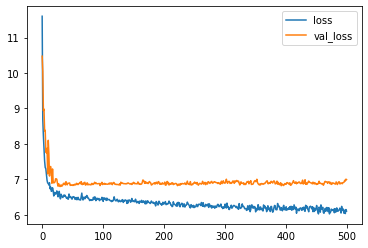

In [53]:
loss_df = pd.DataFrame(model.history.history)
loss_df.plot()

## Test/training data eval

In [54]:
print("Test data evaluation:")
print(model.evaluate(X_test, y_test, verbose=0))
print("\nTrain data evaluation:")
print(model.evaluate(X_train, y_train, verbose=0))

Test data evaluation:
6.740983009338379

Train data evaluation:
5.983172416687012


## Get test predictions for evaluation metrics

In [55]:
test_predictions = model.predict(X_test)

test_predictions = pd.Series(test_predictions.reshape(len(y_test),))
pred_df = pd.DataFrame(np.asarray(y_test), columns=['Test True Y'])
pred_df = pd.concat([pred_df, test_predictions], axis=1)
pred_df.columns = ['Test True Y', 'Model Predictions']


pred_df

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


,Test True Y,Model Predictions
0,5.39,4.12
1,5.99,3.83
2,3.28,3.43
3,1.41,3.49
4,2.63,3.68
...,...,...
282,2.49,3.93
283,3.10,3.46
284,1.67,3.70
285,2.35,4.00


## Metrics

<AxesSubplot:xlabel='Test True Y', ylabel='Model Predictions'>

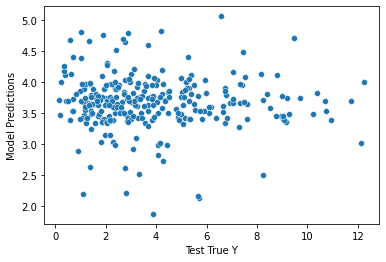

In [56]:
sns.scatterplot(x='Test True Y', y='Model Predictions', data=pred_df)

## Error regression metrics

In [57]:
# MAE - Mean average error
print("MAE")
print(round(metrics.mean_absolute_error(y_test, test_predictions), 2), "sec")

# MSE - Mean square error
print("\nMSE")
print(round(metrics.mean_squared_error(y_test, test_predictions), 2), "sec^2")

# RMSE - Root mean square error
print('\nRMSE:')
print(round(np.sqrt(metrics.mean_squared_error(y_test, test_predictions)), 2), "sec")

# R-squared. 0 = the model descibes the dataset poorly
# 1 = model describes the dataset perfectly
print('\nR-squared:')
print(round(metrics.r2_score(y_test, test_predictions), 2))

# Explained Variance Score => 0 = the model descibes the dataset poorly
# 1 = model describes the dataset perfectly
# high variance score = model is a good fit for the data 
# low variance score = model is not a good fit for the data
# the higher the score, the model is more able to explain the variation in the data
# if score is low, we might need more and better data
print("\nExplained variance score:")
print(round(metrics.explained_variance_score(y_test, test_predictions), 2))

MAE
2.03 sec

MSE
6.74 sec^2

RMSE:
2.6 sec

R-squared:
-0.05

Explained variance score:
-0.05


As we see real bad results. We've already tried a lot of combinations of layers and nodes...

<AxesSubplot:xlabel='Bounce Rate', ylabel='Count'>

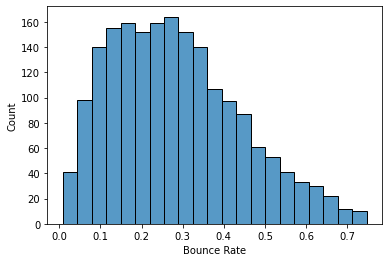

In [19]:
sns.histplot(df['Bounce Rate'])

In [ ]:
# sns.histplot(df['Page Views'])

<AxesSubplot:xlabel='Previous Visits', ylabel='Count'>

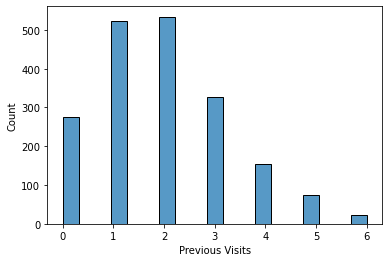

In [21]:
sns.histplot(df['Previous Visits'])

<AxesSubplot:xlabel='Session Duration', ylabel='Count'>

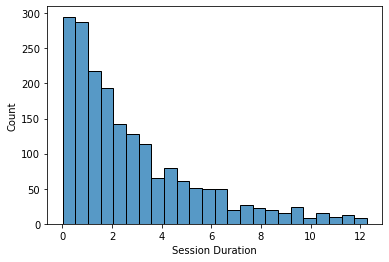

In [22]:
sns.histplot(df['Session Duration'])

<AxesSubplot:xlabel='Time on Page', ylabel='Count'>

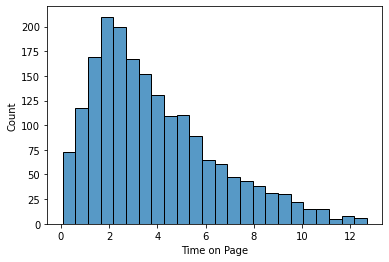

In [23]:
sns.histplot(df['Time on Page'])

I am going to try something, we did the KBest calculations, and Page Views did not come out very well. So let's try to build the ANN without this variable. Okay, that also didn't do the job.